In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.optimize as optimize
from matplotlib import ticker
import matplotlib.patheffects as mpe

from shapely import LineString

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_ui as fui
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09e-6

In [2]:
data_folder = r"D:\[Code]\paper01\data"
figures_folder = r"D:\[Code]\paper01\figures"

In [3]:
"""FLIM data"""
time_data = fp.open_flim(
    os.path.join(data_folder, "time_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
time_features = fg.load_features(data_folder, "time_features.shp", "time_features.npz")

"""Open flim .json"""
with open(os.path.join(data_folder, "time.json"), "r") as file:
    time_info = json.load(file)

"""Load Potential and Current data from ivium file"""
time_ivium = IviumFile()
time_ivium.set_path(os.path.join(data_folder, "time_ivium1428.csv"))
time_ivium.read_data_from_file()

"""Timestamps and frames"""
t_start = 30  # seconds
delta_t = 10  # seconds
t_eval = np.arange(t_start, 180, delta_t)
# Fo_eval = (t_eval - t_start) * diff_OH / (2 * radius_particle_AC) ** 2

time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
flim_frames = flim_frames = fp.timestamp2frame_flim(t_eval, time_info, offset_flim=-5)[
    "flim_frames"
]

"""Results"""
time_results_8rays = pd.read_csv(
    os.path.join(data_folder, "time_results_8rays.csv"),
    index_col=0,
)
time_results_40s_allrays = pd.read_csv(
    os.path.join(data_folder, "time_results_40s_allrays.csv"),
    index_col=0,
)  #
time_profiles = pd.read_csv(
    os.path.join(data_folder, "time_profiles.csv"),
    index_col=0,
)  #

In [4]:
particle = [f for f in time_features if f.name == "particle"][0]
wall = [f for f in time_features if f.name == "wall"][0]
membrane = [f for f in time_features if f.name == "membrane"][0]
volume = [f for f in time_features if f.name == "volume"][0]

extent = fa.get_extent(time_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    time_data["intensity"][0].shape[1],
    0,
    time_data["intensity"][0].shape[0],
]

In [5]:
distance_end_point = 200
number_rays = 360
pulling_bearing = 5

base_points = fa.get_points_along_line_number(
    particle.geometry.exterior, number_rays
)  # type:ignore
rays = fg.get_rays_of_sphere_like_base_points(base_points, pulling_bearing)

for i_ray, ray in enumerate(rays):
    ray.set_end_point_image(time_data["intensity"][0])
    ray.set_end_point_volume(volume.geometry)
    ray.set_end_point(distance_end_point)

ray_lines = []
for ray in rays:
    line = LineString([ray.base_point, ray.end_point_image])
    ray_lines.append(line)
    
chosen_ray_numbers = [-40, -5, 35, 72, 133, 175, 225, 268]
chosen_rays = []
for number in chosen_ray_numbers:
    if number < 0:
        number += 360 - 1
    chosen_rays.append(rays[number])

90.0 74.53531065934328
89.0 69.64389143681416
88.0 66.48200507615252
87.0 65.73002512482816
86.0 65.87697636724192
85.0 67.49965140427781
84.0 68.2211408088329
83.0 67.49464326786227
82.0 66.6488439515773
81.0 66.2768270800508
80.0 67.551527401702
79.0 70.54145899615747
78.0 73.50980772808254
77.0 75.96342132769257
76.0 77.21913937888655
75.0 75.91756460786718
74.0 72.4794063782922
73.0 68.57434324247703
72.0 64.80422465994394
71.0 61.39645668135648
70.0 58.645053018727594
69.0 56.761217904858654
68.0 55.742456293181306
67.0 55.16426787503792
66.0 55.19440874649331
65.0 55.67323438248695
64.0 55.632065706519654
63.0 55.74076695644993
62.0 55.22196442251044
61.0 53.08747316062579
60.0 50.01207873836415
59.0 46.01985518224842
58.0 41.90631935736678
57.0 38.947033022855805
56.0 37.57649455932034
55.0 37.18473953840862
54.0 38.11682632716048
53.0 39.65796043178034
52.0 40.63177962937357
51.0 41.446370600026796
50.0 41.86848606348036
49.0 40.79777746075382
48.0 38.76036997759451
47.0 38.021

In [20]:
numerator_list = ["D'", "A'", "D", "C", "B", "A", "B'", "C'"]
cmap = plt.get_cmap("cmo.tempo")  # type:ignore
colors_list = cmap(np.linspace(0.2, 0.7, 4))
colors = [
    colors_list[1],
    colors_list[2],
    colors_list[3],
    colors_list[2],
    colors_list[1],
    colors_list[0],
    colors_list[3],
    colors_list[0],
]
colors = colors[::-1]

In [21]:
frame_index = 4
time_data_ray = time_results_8rays.query(
    f"lifa_frame == {flim_frames[frame_index]}"
).copy()
time_data_ray.head()

,i_ray,ray,image_angle,time,count_frame,lifa_frame,peak_id,fit_window_end,peak,m,delta,surface_delta_oh_minus,peak_delta_oh_minus,bulk_delta_oh_minus,flow_angle,distance,sigma
688,0,-40,129.297924,39.044,86,160,0.0,23.0,0.00,-1.850698,0.540337,0.000184,0.000184,-0.000023,-140.702076,0.000246,0.599195
689,1,-5,87.912050,39.044,86,160,15.0,41.0,0.30,-1.092351,1.215457,0.000089,0.000108,-0.000023,177.912050,0.000552,0.090061
690,2,35,37.184740,39.044,86,160,11.0,48.0,0.22,-0.954913,1.267216,0.000315,0.000376,0.000005,127.184740,0.000576,0.044227
691,3,72,6.522657,39.044,86,160,13.0,47.0,0.26,-0.860351,1.422317,0.000401,0.000538,-0.000051,96.522657,0.000646,0.069991
692,4,133,326.455749,39.044,86,160,0.0,61.0,0.00,-0.565854,1.767240,0.000404,0.000404,0.000005,56.455749,0.000803,0.370828


# Figure 3

 1 A'    177.91  0.001 POINT (245.0554121123357 370.37906246054024)
 5 A      -0.03  0.001 POINT (215.92306130504278 37.122354184014)
 4 B      56.46  0.001 POINT (323.2611203393475 110.57453786438458)
 6 B'    -60.05  0.001 POINT (106.96056050022665 133.4124544725426)
 3 C      96.52  0.001 POINT (363.52257579442517 236.0598991762201)
 7 C'    -89.55  0.000 POINT (113.56499430247746 229.3072382151313)
 0 D'   -140.70  0.000 POINT (194.2051819909737 300.6318802154828)
 2 D     127.18  0.001 POINT (333.84217353066975 314.1062204247335)
141 141 141 141 141
140 140 137 137 140


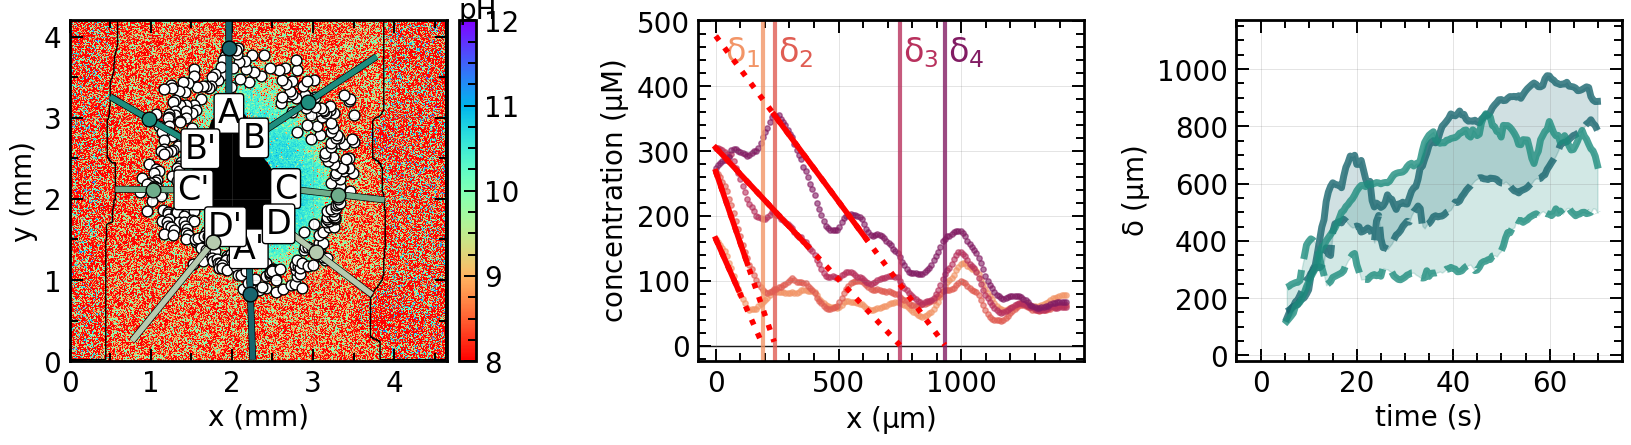

In [39]:
gs_kw = dict(width_ratios=[3, 2, 2])

fig, axes = plt.subplots(1, 3, figsize=(17.8, 5), gridspec_kw = gs_kw)
frame_index = 4
ray_step = 1

"""Figure 3A - Time Case"""
ax = axes.ravel()[0]

# setup
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_ylim(extent[2], extent[3])
ax.set_xlim(extent[0], extent[1])


# background
img = ax.imshow(
    time_data["value"][flim_frames[frame_index]],
    cmap="rainbow_r",
    vmin=8,
    vmax=12,
    extent=extent,
)
clb = plt.colorbar(img, pad=0.02)
clb.set_label("pH", labelpad=-30, y=1.07, rotation=0)
clb.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
clb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

# boundary layer thickness
points = []
for i_ray, index_ray in enumerate(
    time_results_40s_allrays.query("(sigma < 0.6)").i_ray.unique()
):
    if (i_ray % ray_step != 1) and (i_ray / ray_step != i_ray):
        continue
    ray = rays[index_ray]
    ray_data = time_results_40s_allrays.loc[
        time_results_40s_allrays["i_ray"] == index_ray
    ].iloc[0]
    layer_end_point = fa.get_point_from_angle(
        ray.base_point, ray.angle, ray_data.distance / pixel_size
    )
    points.append(
        fa.affine_transform_pixel2extent(layer_end_point, geom_extent, list(extent))
    )
gpd.GeoSeries(points).plot(
    ax=ax, facecolor="white", edgecolor="black", markersize=60, alpha=1
)


# plotting - features
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(particle.geometry, geom_extent, list(extent))
).plot(ax=ax, color="black")
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(membrane.geometry, geom_extent, list(extent))
).exterior.plot(ax=ax, color="black", lw=1)
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(wall.geometry, geom_extent, list(extent))
).exterior.plot(ax=ax, color="black", lw=1)

# plotting - rays
for i_letter, letter in enumerate(["A", "B", "C", "D"]):
    for i_ray, (ray, index_ray) in enumerate(zip(chosen_rays, chosen_ray_numbers)):
        if letter in numerator_list[i_ray]:
            ray_data = time_data_ray.query(f"i_ray == {i_ray}")
            layer_end_point = fa.get_point_from_angle(
                ray.base_point, ray.angle, ray_data.distance.values[0] / pixel_size
            )
            print(
                f"{i_ray:2d} {numerator_list[i_ray]:<3s} {ray_data.flow_angle.values[0]:>8.2f} {ray_data.distance.values[0]:>6.3f}",
                layer_end_point,
            )
            pe1 = [mpe.Stroke(linewidth=5, foreground="black"), mpe.Normal()]
            gpd.GeoSeries(
                fa.affine_transform_pixel2extent(
                    ray.evaluation_line, geom_extent, list(extent)
                )
            ).plot(
                ax=ax,
                color=colors[i_ray],
                lw=4,
                path_effects=pe1,
            )

            gpd.GeoSeries(
                fa.affine_transform_pixel2extent(
                    layer_end_point, geom_extent, list(extent)
                )
            ).plot(
                ax=ax,
                facecolor=colors[i_ray],
                edgecolor="black",
                marker=".",
                markersize=450,
                zorder=999,
            )
            label_point = fa.affine_transform_pixel2extent(
                ray.base_point, geom_extent, list(extent)
            )

            ax.text(
                label_point.x,
                label_point.y,
                f"{numerator_list[i_ray]}",
                bbox=dict(
                    facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"
                ),
                horizontalalignment="center",
                verticalalignment="center",
            )

"""Figure 3B - Method"""

# settings
fraction_limit = 0.5
min_pixel = 10
indices_time = [20, 60, 110, 150]  # , 32
graph_label = [
    r"$t_0$ = 0s",
    r"$t_1$ > $t_0$",
    r"$t_2$ > $t_1$",
    r"$t_3$ > $t_2$",
    r"$t_4$ > $t_3$",
]
bl_labels = [r"$\delta_1$", r"$\delta_2$", r"$\delta_3$", r"$\delta_4$"]
cmap2 = plt.get_cmap("cmo.matter")  # type:ignore
colors2 = cmap2(np.linspace(0.25, 0.75, len(indices_time)))

# setup
ax = axes.ravel()[1]
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("concentration ($\mu$M)")
ax.axhline(0, color="black", alpha=1, zorder=-10, lw=1)
# ax.set_xlim(-0.05 * radius_particle_AC * 1e6, radius_particle_AC * 1e6 * 2)

# plotting lines
count_time = 0
for i_time, time in enumerate(time_profiles.time.unique()):
    if i_time not in indices_time:
        continue
    profile = time_profiles.query("time == @time")

    xs = profile.r.to_numpy()
    ys = profile.rolled_values.to_numpy() * 1e6

    """Peak Detection"""
    peaks, properties = sig.find_peaks(
        ys[xs <= radius_particle_AC * 1e6],
        height=ys.max() * 0.7,
        prominence=1e-10,
    )

    peak_indices = peaks
    peak_heights = properties["peak_heights"]

    try:
        peak_index = peaks[np.argmax(properties["prominences"])]
    except ValueError as e:
        peak_index = 0

    if ys[0] >= ys[peak_index] * 1.0:
        peak_index = 0

    peak_loc = xs[peak_index]
    peak_height = ys[peak_index]

    ax.scatter(xs, ys, color=colors2[count_time], s=15, alpha=0.6)

    """linear fit + boundary layer thickness calculation"""

    indices_below_threshold = np.where(ys[peak_index:] < peak_height * fraction_limit)[
        0
    ]
    fit_window_end = (
        indices_below_threshold[(indices_below_threshold - peak_index) > min_pixel][0]
        + peak_index
    )
    # print(peak_index, fit_window_end)
    ps, _ = optimize.curve_fit(
        fa.linear,
        xs[peak_index:fit_window_end],
        ys[peak_index:fit_window_end],
        p0=[-1e-1, peak_height],
    )
    m = ps[0]
    n = ps[1]
    delta = -peak_height / m + peak_loc
    # print(m, n, delta)
    x_fit = xs[peak_index:fit_window_end] - peak_loc
    x_regression = xs - peak_loc
    y_fit = fa.linear(x_fit, m, peak_height)
    y_regression = fa.linear(x_regression, m, peak_height)

    ax.plot(
        x_fit[y_fit > fraction_limit] + peak_loc,
        y_fit[y_fit > fraction_limit],
        color="red",
        lw=4,
        zorder=100,
    )
    ax.plot(
        x_regression[y_regression > -0.1] + peak_loc,
        y_regression[y_regression > -0.1],
        color="red",
        ls=":",
        lw=4,
        zorder=100,
    )
    # ax.axvline(x=xs[fit_window_end], color="red", lw=3, alpha=0.7)
    ax.axvline(x=delta, color=colors2[count_time], lw=3, alpha=0.8)
    if count_time == 0:
        x_offset = -10
        ha = "right"
    else:
        x_offset = 10
        ha = "left"
    ax.text(
        x=delta + x_offset,
        y=480,
        s=bl_labels[count_time],
        color=colors2[count_time],
        horizontalalignment=ha,
        verticalalignment="top",
    )

    count_time += 1

"""Figure 3C - Evolution Time"""
# settings
max_time = 70
min_time = 5
data_80s = time_results_8rays.query("@min_time <= time <= @max_time")
chosen_numerator = ["A", "A'", "B", "B'", "C", "C'", "D", "D'"]
rolling_window = 21
zero_pulling = rolling_window // 2

# setup
ax = axes.ravel()[2]
ax.set_xlim(-5, max_time + 5)
ax.set_ylim(-20, 1170)
# ax.set_ylim(-0.2, 5.2)
# ax.set_xlim(-5, 155)
# ax.set_ylim(-0.2, 5.2)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
ax.set_xlabel("time (s)")
ax.set_ylabel(r"$\delta$ ($\mu$m)")

# plotting
for letter_membrane in ["A", "B"]:
    letter_wall = letter_membrane + "'"
    membrane_facing = (
        data_80s.query(
            f"i_ray == {numerator_list.index(letter_membrane)} and (delta < 4.5 and delta >= 0)"
        )
        .sort_values(by="time")
        .copy()
    )

    wall_facing = (
        data_80s.query(
            f"i_ray == {numerator_list.index(letter_wall)} and (delta < 4.5 and delta >= 0)"
        )
        .sort_values(by="time")
        .copy()
    )

    x_membrane = membrane_facing.time
    y_membrane = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(membrane_facing["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )[zero_pulling:]
        * 1e6
    )
    x_wall = wall_facing.time
    y_wall = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(wall_facing["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )[zero_pulling:]
        * 1e6
    )

    y_wall_interp = np.interp(x_membrane, x_wall, y_wall)

    print(
        x_membrane.size, y_membrane.size, x_wall.size, y_wall.size, y_wall_interp.size
    )
    ax.fill_between(
        x_membrane,
        y_membrane,
        y_wall_interp,
        color=colors[numerator_list.index(letter_membrane)],
        alpha=0.2,
    )
    ax.plot(
        x_membrane,
        y_membrane,
        color=colors[numerator_list.index(letter_membrane)],
        ls="-",
        alpha=0.8,
        label=letter_membrane,
    )
    ax.plot(
        x_wall,
        y_wall,
        color=colors[numerator_list.index(letter_membrane)],
        ls="--",
        alpha=0.8,
    )


"""
for numerator in chosen_numerator:
    i_numerator = numerator_list.index(numerator)
    print(numerator, i_numerator)
    ray_data = (
        data_80s.query(f"i_ray == {i_numerator} and (delta < 4.5 and delta >= 0)")
        .sort_values(by="time")
        .copy()
    )
    ray_data_bad = data_80s.query(
        f"i_ray == {i_numerator} and (delta > 4.5 or delta < 0)"
    ).copy()
    print(ray_data.shape)

    delta_rolled = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(ray_data["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )
        * 1e6
    )
    if "'" in numerator_list[i_numerator]:
        ls = ":"
    else:
        ls = "-"
    ax.plot(
        ray_data.time, delta_rolled[zero_pulling:], color=colors[i_numerator], ls=ls
    )
"""

plt.tight_layout()
fig.savefig(os.path.join(figures_folder, "figure03.png"), dpi=200)
plt.show()

# Figure 03 C

141 141 141 141 141


IndexError: index 5 is out of bounds for axis 0 with size 4

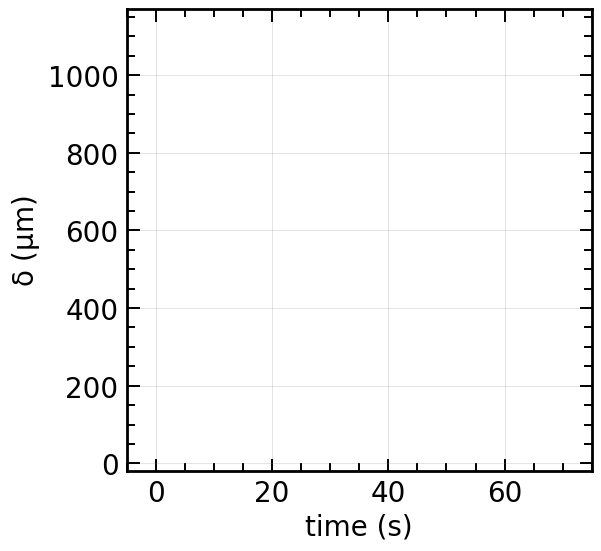

In [11]:
for letter_membrane in ["A", "C"]:
    letter_wall = letter_membrane + "'"
    membrane_facing = (
        data_80s.query(
            f"i_ray == {numerator_list.index(letter_membrane)} and (delta < 4.5 and delta >= 0)"
        )
        .sort_values(by="time")
        .copy()
    )

    wall_facing = (
        data_80s.query(
            f"i_ray == {numerator_list.index(letter_wall)} and (delta < 4.5 and delta >= 0)"
        )
        .sort_values(by="time")
        .copy()
    )

    x_membrane = membrane_facing.time
    y_membrane = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(membrane_facing["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )[zero_pulling:]
        * 1e6
    )
    x_wall = wall_facing.time
    y_wall = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(wall_facing["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )[zero_pulling:]
        * 1e6
    )

    y_wall_interp = np.interp(x_membrane, x_wall, y_wall)

    print(
        x_membrane.size, y_membrane.size, x_wall.size, y_wall.size, y_wall_interp.size
    )
    ax.fill_between(
        x_membrane,
        y_membrane,
        y_wall_interp,
        color=colors[numerator_list.index(letter_membrane)],
        alpha=0.2,
    )
    ax.plot(
        x_membrane,
        y_membrane,
        color=colors[numerator_list.index(letter_membrane)],
        ls="-",
        alpha=0.8,
        label = letter_membrane
    )
    ax.plot(
        x_wall,
        y_wall,
        color=colors[numerator_list.index(letter_wall)],
        ls="--",
        alpha=0.8,
    )


"""
for numerator in chosen_numerator:
    i_numerator = numerator_list.index(numerator)
    print(numerator, i_numerator)
    ray_data = (
        data_80s.query(f"i_ray == {i_numerator} and (delta < 4.5 and delta >= 0)")
        .sort_values(by="time")
        .copy()
    )
    ray_data_bad = data_80s.query(
        f"i_ray == {i_numerator} and (delta > 4.5 or delta < 0)"
    ).copy()
    print(ray_data.shape)

    delta_rolled = (
        fa.rollavg_convolve_edges(
            np.insert(
                np.array(ray_data["distance"]),
                np.zeros(zero_pulling, dtype="int"),
                np.zeros(zero_pulling),
            ),
            rolling_window,
        )
        * 1e6
    )
    if "'" in numerator_list[i_numerator]:
        ls = ":"
    else:
        ls = "-"
    ax.plot(
        ray_data.time, delta_rolled[zero_pulling:], color=colors[i_numerator], ls=ls
    )
"""
plt.legend()
fig.savefig(os.path.join(figures_folder, "figure03_C.png"), dpi=100)
plt.show()